<b>Construction of an optical (G) / infrared (J) color-magnitude diagram comparing the open cluster galaxies: Messier 23 (NGC 6494) and Messier 25 (IC 4725) of the Sagittarius constellation.</b>

In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle, Distance

# Right ascension
m23_ra = '17h56m56.9s'
m25_ra = '18h31m44.9s'

# Declination
m23_dec = '-18d59m13s'
m25_dec = '-19d06m50s'

# Distance
m23_dist = Distance(parallax = Angle(1.354*u.mas))
m25_dist = Distance(parallax = Angle(1.5043*u.mas))

# Right ascension of proper motion
m23_pm_ra = 0.284 * u.mas / u.yr
m25_pm_ra = -1.7201 * u.mas / u.yr

# Declination of proper motion
m23_pm_dec = -1.809 * u.mas / u.yr
m25_pm_dec = -6.1010 * u.mas / u.yr

# Galactic center coordinates
m23_center_coords_3d = SkyCoord(ra = m23_ra,
                                    dec = m23_dec,
                                    distance = m23_dist,
                                    pm_ra_cosdec = m23_pm_ra,
                                    pm_dec = m23_pm_dec)

m25_center_coords_3d = SkyCoord(ra = m25_ra,
                                    dec = m25_dec,
                                    distance = m25_dist,
                                    pm_ra_cosdec = m25_pm_ra,
                                    pm_dec = m25_pm_dec)

In [2]:
from astroquery.vizier import Vizier
from astropy.time import Time
import numpy as np


v = Vizier(catalog = "I/350")
v.ROW_LIMIT = -1

# Query all Gaia stars within 0.5 degrees of the cluster center
m23_query = v.query_region(m23_center_coords_3d, radius = 0.5 * u.deg)
m23_gaia_table = m23_query[0]

m25_query = v.query_region(m25_center_coords_3d, radius = 0.5 * u.deg)
m25_gaia_table = m25_query[0]

# Remove stars that are too faint
m23_gaia_table = m23_gaia_table[m23_gaia_table['Gmag'] < 19]
m25_gaia_table = m25_gaia_table[m25_gaia_table['Gmag'] < 19]

# Remove stars that are too far away
m23_gaia_table = m23_gaia_table[m23_gaia_table['Plx'] > 0.25 * u.mas]
m25_gaia_table = m25_gaia_table[m25_gaia_table['Plx'] > 0.25 * u.mas]

# Coordinates of queried stars
m23_coords = SkyCoord(
    ra = m23_gaia_table['RA_ICRS'],
    dec = m23_gaia_table['DE_ICRS'],
    distance = Distance(parallax = Angle(m23_gaia_table['Plx'])),
    pm_ra_cosdec = m23_gaia_table['pmRA'],
    pm_dec = m23_gaia_table['pmDE'],
    obstime = Time('J2016'))

m25_coords = SkyCoord(
    ra = m25_gaia_table['RA_ICRS'],
    dec = m25_gaia_table['DE_ICRS'],
    distance = Distance(parallax = Angle(m25_gaia_table['Plx'])),
    pm_ra_cosdec = m25_gaia_table['pmRA'],
    pm_dec = m25_gaia_table['pmDE'],
    obstime = Time('J2016'))

# Calculate 3D separations
m23_sep3d = m23_coords.separation_3d(m23_center_coords_3d)
m25_sep3d = m25_coords.separation_3d(m25_center_coords_3d)

# Calculate velocity space separations
m23_pm_diff = np.sqrt(
    (m23_coords.pm_ra_cosdec - m23_center_coords_3d.pm_ra_cosdec)**2 + 
    (m23_coords.pm_dec - m23_center_coords_3d.pm_dec)**2)

m25_pm_diff = np.sqrt(
    (m25_coords.pm_ra_cosdec - m25_center_coords_3d.pm_ra_cosdec)**2 + 
    (m25_coords.pm_dec - m25_center_coords_3d.pm_dec)**2)

# Remove stars further than 50 parsecs and have more than 1.5 milliarcsecond per year proper motions
m23_members = (m23_sep3d < 50 * u.pc) & (m23_pm_diff < 1.5 * u.mas / u.yr)
m23_coords = m23_coords[m23_members]

m25_members = (m25_sep3d < 50 * u.pc) & (m25_pm_diff < 1.5 * u.mas / u.yr)
m25_coords = m25_coords[m25_members]

In [3]:
print(len(m23_coords))
print(len(m25_coords))

772
542


In [4]:
# Load cluster stars from 2MASS catalogue
v = Vizier(catalog="II/246", columns=['*', 'Date'])
v.ROW_LIMIT = -1

m23_result = v.query_region(m23_center_coords_3d, radius=0.5 * u.deg)
m23_2mass = m23_result[0]

m25_result = v.query_region(m25_center_coords_3d, radius=0.5 * u.deg)
m25_2mass = m25_result[0]

In [5]:
print(len(m23_2mass))
print(len(m25_2mass))

72153
65540


In [6]:
print(np.unique(m23_2mass['Date']))
print(np.unique(m25_2mass['Date']))

   Date   
----------
1998-05-18
1998-06-14
   Date   
----------
1998-06-03
1998-06-24
1999-07-07


In [7]:
print(len(m23_2mass[m23_2mass['Date'] == '1998-05-18']))
print(len(m23_2mass[m23_2mass['Date'] == '1998-06-14']))
print()
print(len(m25_2mass[m25_2mass['Date'] == '1998-06-03']))
print(len(m25_2mass[m25_2mass['Date'] == '1998-06-24']))
print(len(m25_2mass[m25_2mass['Date'] == '1999-07-07']))

10274
61879

16961
3241
45338


In [8]:
# Define Time object for 2MASS observation date
m23_2mass_epoch = Time(np.unique(m23_2mass['Date'][-1]))
m25_2mass_epoch = Time(np.unique(m25_2mass['Date'][-1]))

# Define SkyCoord object for 2MASS stars
m23_2mass_coords = SkyCoord(m23_2mass['RAJ2000'], m23_2mass['DEJ2000'])
m25_2mass_coords = SkyCoord(m25_2mass['RAJ2000'], m25_2mass['DEJ2000'])

# Advance Gaia coordinates to the 2MASS observation date so that we could compare the two together
m23_coords_1998 = m23_coords.apply_space_motion(m23_2mass_epoch)
m25_coords_1999 = m25_coords.apply_space_motion(m25_2mass_epoch)

# Cross-match
m23_idx_gaia, m23_sep2d_gaia, m23_sep3d = m23_coords_1998.match_to_catalog_sky(m23_2mass_coords)
m25_idx_gaia, m25_sep2d_gaia, m25_sep3d = m25_coords_1999.match_to_catalog_sky(m25_2mass_coords)

In [9]:
len(m23_idx_gaia)

772

Text(0.5, 1.0, 'Messier 25')

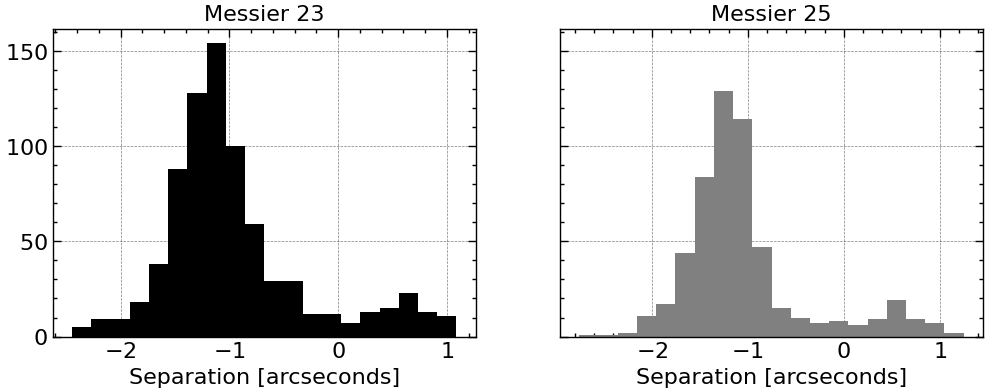

In [18]:
# Determine distances of cross-matched star movement
import matplotlib.pyplot as plt


fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax[0].hist(np.log10(m23_sep2d_gaia.arcsec), bins=20, color='black')
ax[0].set(xlabel=("Separation [arcseconds]"))
ax[0].set_title("Messier 23")

ax[1].hist(np.log10(m25_sep2d_gaia.arcsec), bins=20, color='grey')
ax[1].set(xlabel=("Separation [arcseconds]"))
ax[1].set_title("Messier 25")


In [17]:
# Apparent G (optical) magnitudes
m23_gmag = m23_gaia_table[m23_members]['Gmag']
m25_gmag = m25_gaia_table[m25_members]['Gmag']

# Apparent J (infrared) magnitudes
m23_jmag = m23_2mass['Jmag'][m23_idx_gaia]
m25_jmag = m25_2mass['Jmag'][m25_idx_gaia]

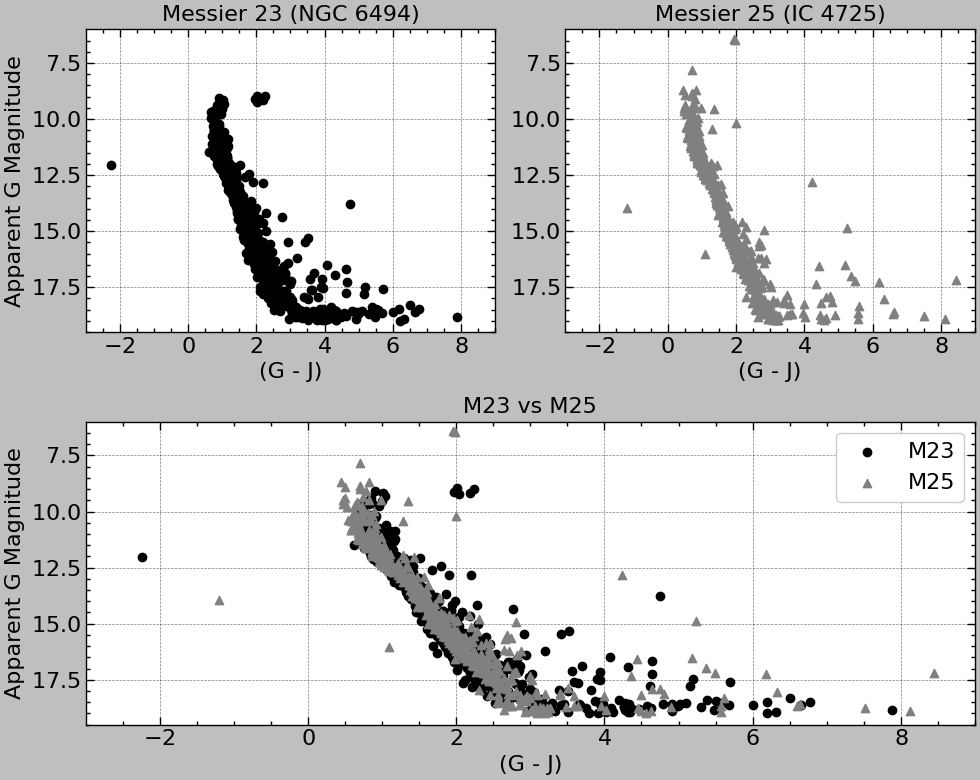

In [16]:
import matplotlib.gridspec as gridspec
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])


with plt.style.context('grayscale'):
    fig = plt.figure(figsize=(10, 8), tight_layout=True)
    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[0])
    ax1.scatter(m23_gmag - m23_jmag, m23_gmag, c='black')
    ax1.set_title('Messier 23 (NGC 6494)')
    ax1.axis(xmin=-3, xmax=9, ymin=19.5, ymax=6)
    ax1.set(xlabel=('(G - J)'), ylabel=('Apparent G Magnitude'))
    
    ax2 = plt.subplot(gs[1])
    ax2.scatter(m25_gmag - m25_jmag, m25_gmag, c='grey', marker='^')
    ax2.set_title('Messier 25 (IC 4725)')
    ax2.axis(xmin=-3, xmax=9, ymin=19.5, ymax=6)
    ax2.set(xlabel=('(G - J)'))

    ax3 = plt.subplot(gs[1, :])
    ax3.scatter(m23_gmag - m23_jmag, m23_gmag, c='black', label='M23')
    ax3.scatter(m25_gmag - m25_jmag, m25_gmag, c='grey', label='M25', marker='^')
    ax3.set_title('M23 vs M25')
    ax3.axis(xmin=-3, xmax=9, ymin=19.5, ymax=6)
    ax3.set(xlabel=('(G - J)'), ylabel=('Apparent G Magnitude'))
    ax3.legend()

    plt.show()